Using TensorFlow backend.


Loading model from models/epoch_11.model...
Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Compiling model...
Embedding images...
tail__Chaetognatha
Eucalanidae
nauplii__Crustacea
egg__other
multiple__Copepoda
Phaeodaria
Ostracoda
Penilia
Limacinidae
Oikopleuridae
nectophore__Diphyidae
Temoridae
Foraminifera
eudoxie__Diphyidae
Oncaeidae
Noctiluca
nauplii__Cirripedia
tail__Appendicularia
Haloptilus
Euchaetidae
multiple__other
Harpacticoida
Evadne
zoea__Decapoda
Salpida
gonophore__Diphyidae
Fritillariidae
Done embedding images.
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2700 samples in 0.043s...
[t-SNE] Computed neighbors for 2700 samples in 0.702s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2700
[t-SNE] Computed conditional probabilities for sample 2000 / 2700
[t-SNE] Computed conditional probabilities for sample 2700 / 2700
[t-SNE] Mean sigma: 0.598950
[t-SNE] KL divergence after 250 iterations with early exaggeration: 120.298256
[t-SNE] Error after 300 iterations: 0.944507
[25 25 25 ...  4  4  4]
Loading model from models/epoch_12.model..

Temoridae
Foraminifera
eudoxie__Diphyidae
Oncaeidae
Noctiluca
nauplii__Cirripedia
tail__Appendicularia
Haloptilus
Euchaetidae
multiple__other
Harpacticoida
Evadne
zoea__Decapoda
Salpida
gonophore__Diphyidae
Fritillariidae
Done embedding images.
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2700 samples in 0.005s...
[t-SNE] Computed neighbors for 2700 samples in 0.674s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2700
[t-SNE] Computed conditional probabilities for sample 2000 / 2700
[t-SNE] Computed conditional probabilities for sample 2700 / 2700
[t-SNE] Mean sigma: 0.362421
[t-SNE] KL divergence after 250 iterations with early exaggeration: 125.240669
[t-SNE] Error after 300 iterations: 1.193329
[25 25 25 ...  4  4  4]
Loading model from models/epoch_20.model...
Compiling model...
Embedding images...
tail__Chaetognatha
Eucalanidae
nauplii__Crustacea
egg__other
multiple__Copepoda
Phaeodaria
Ostracoda
Penilia
Limacinidae
Oikopleuridae
nectophore__Diphyida

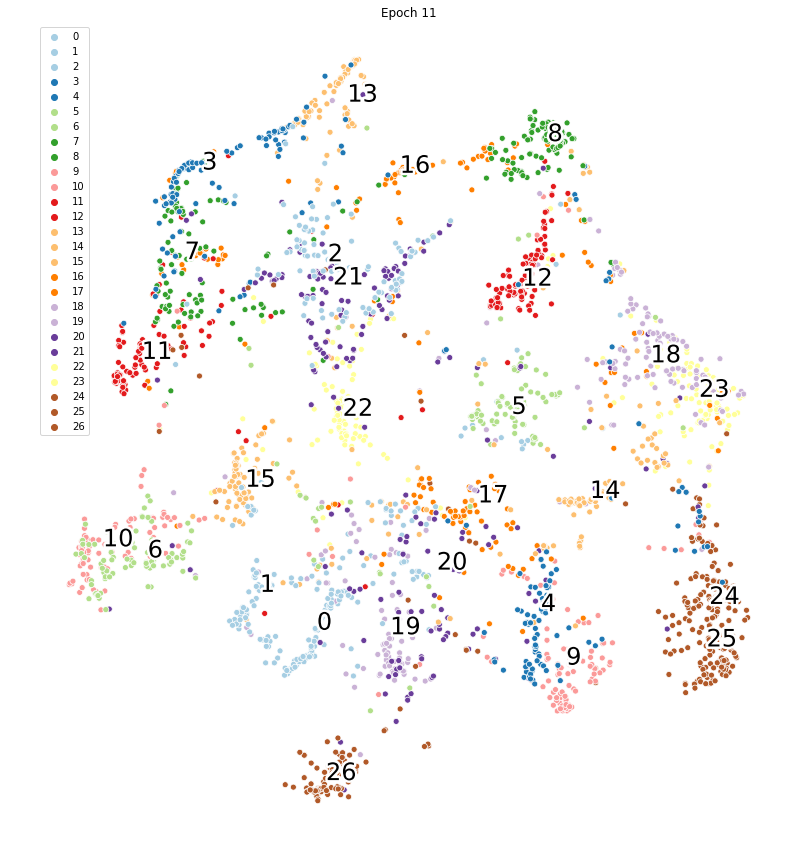

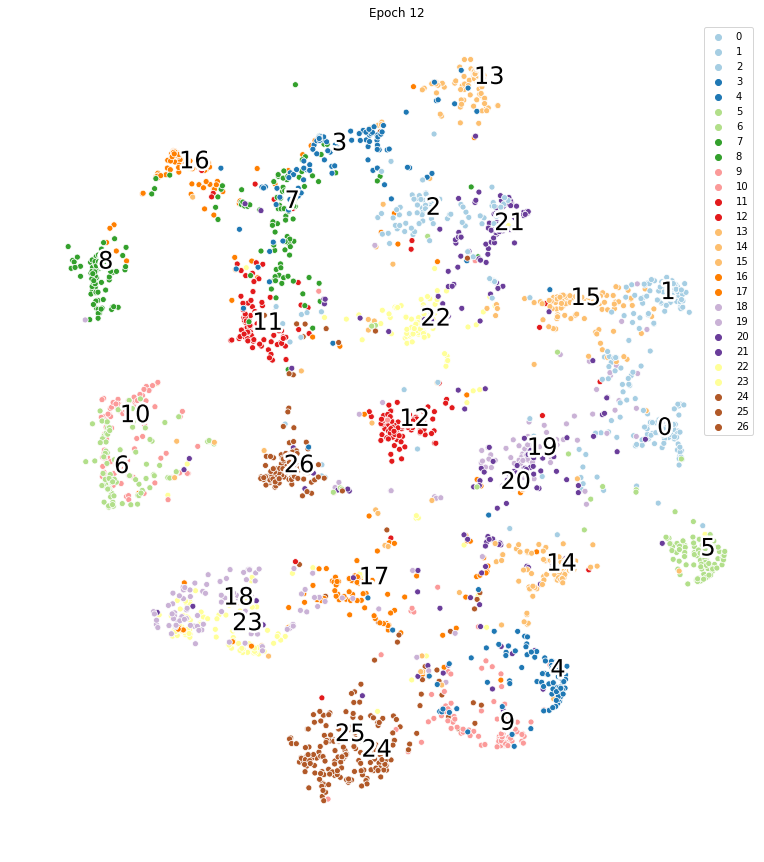

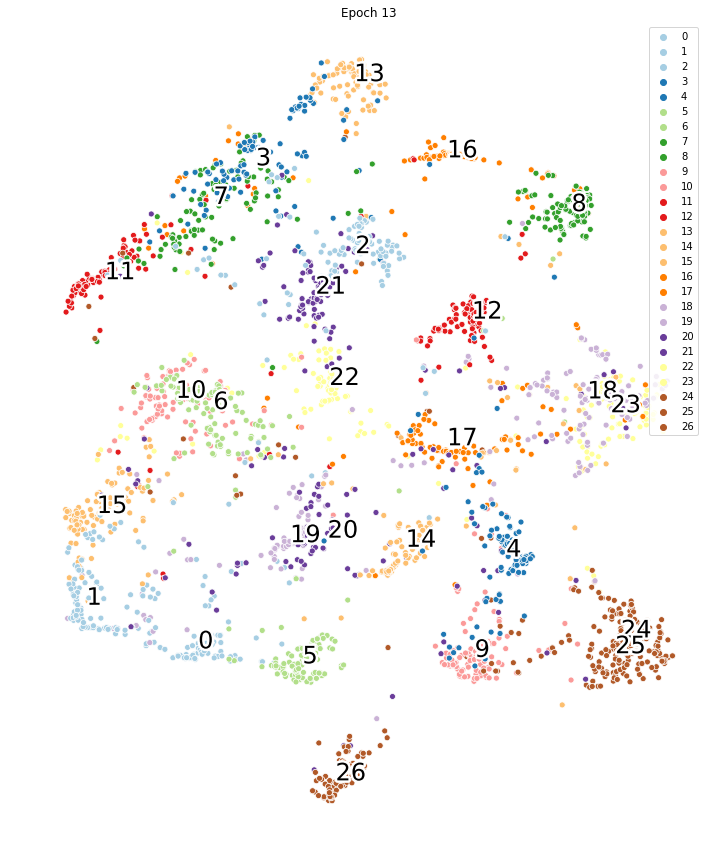

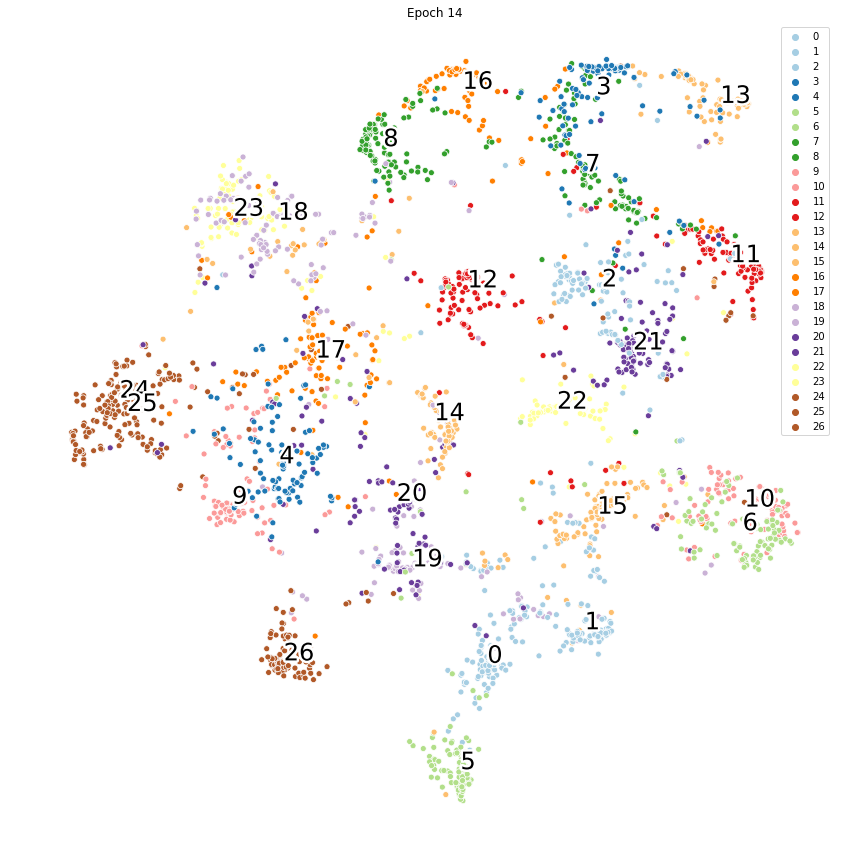

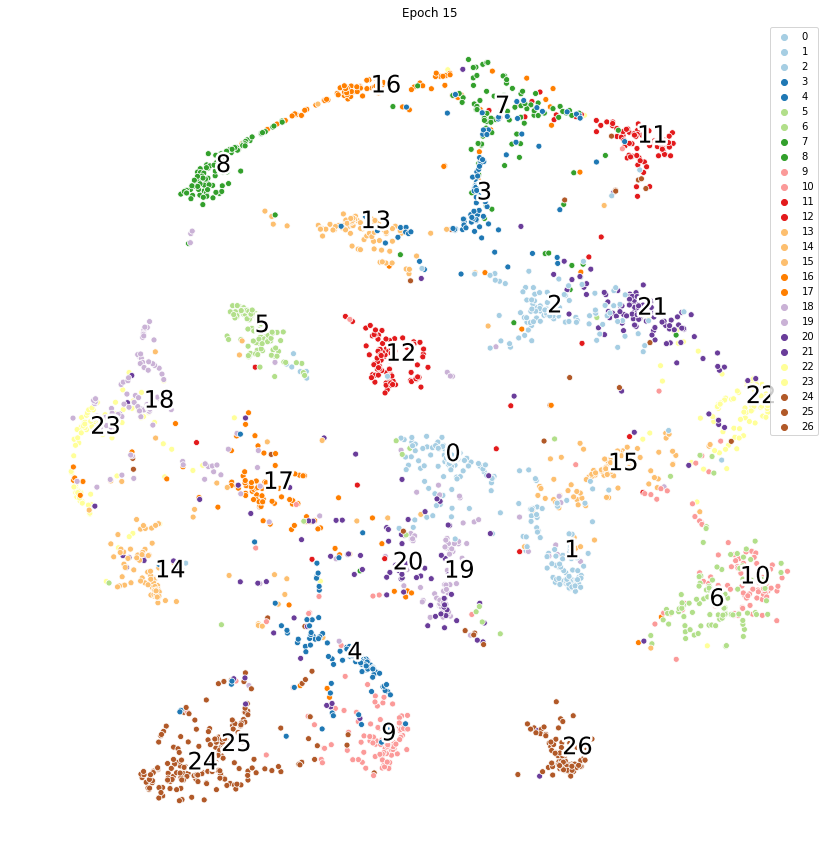

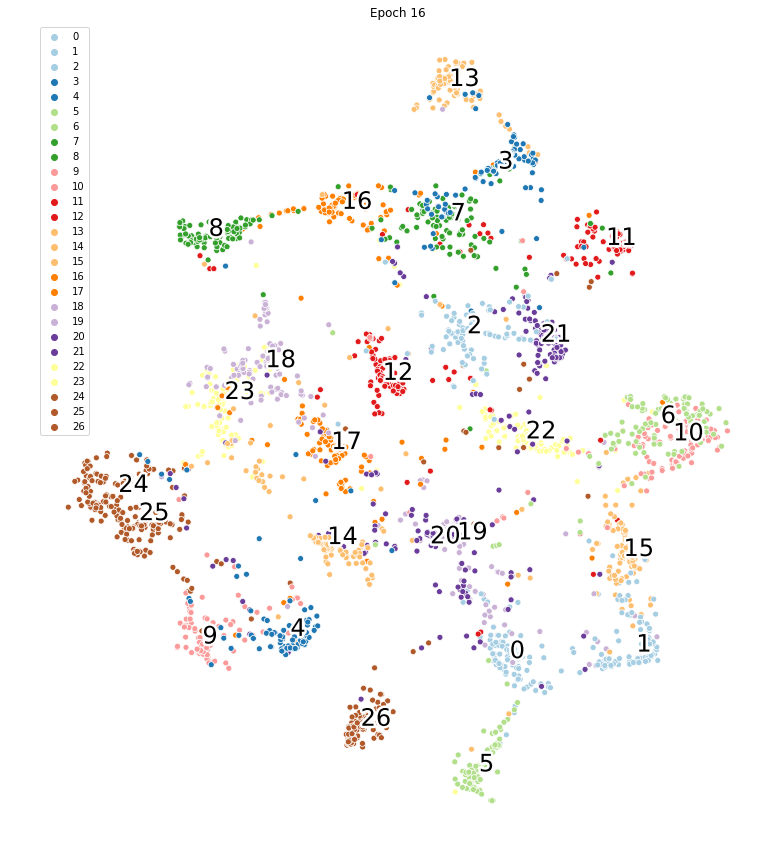

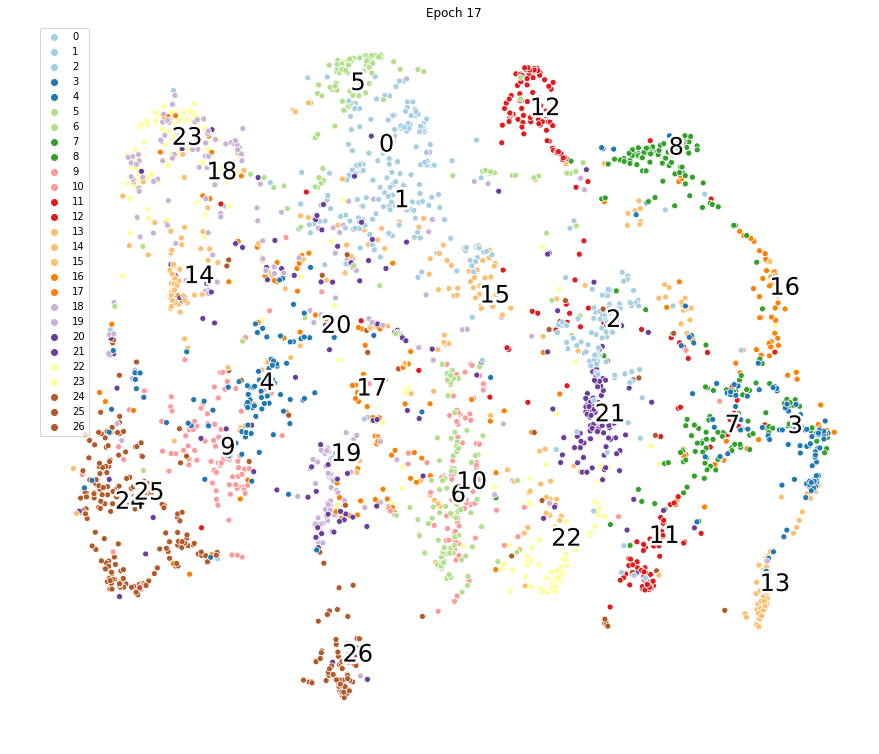

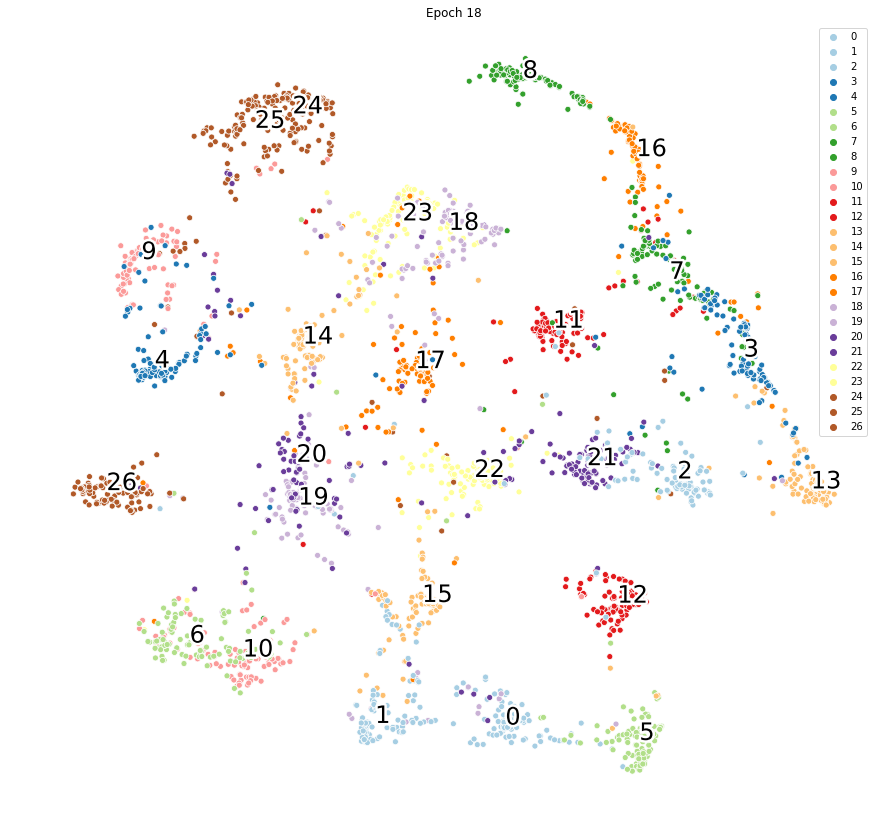

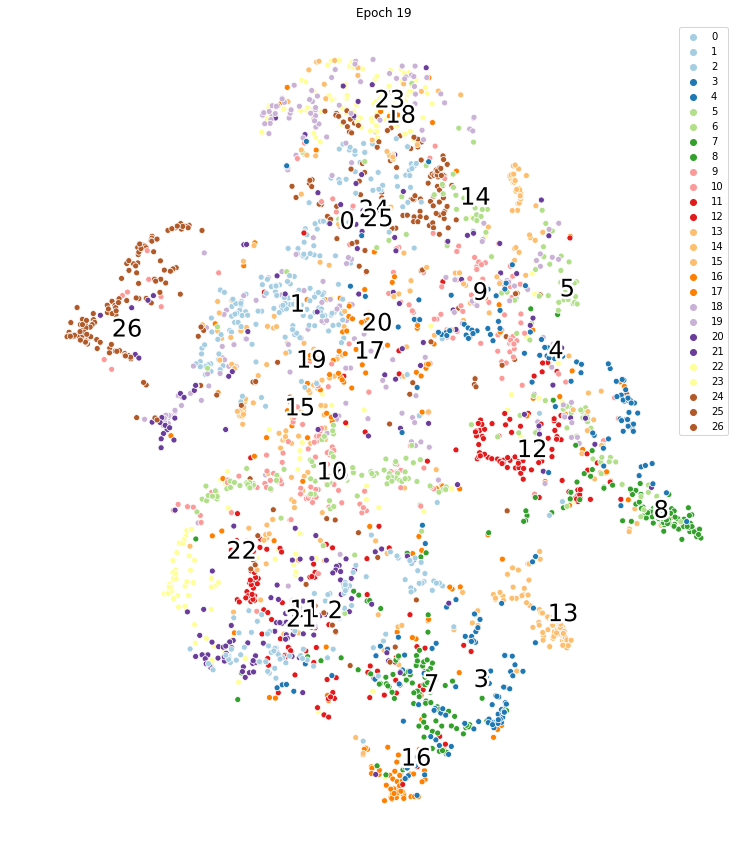

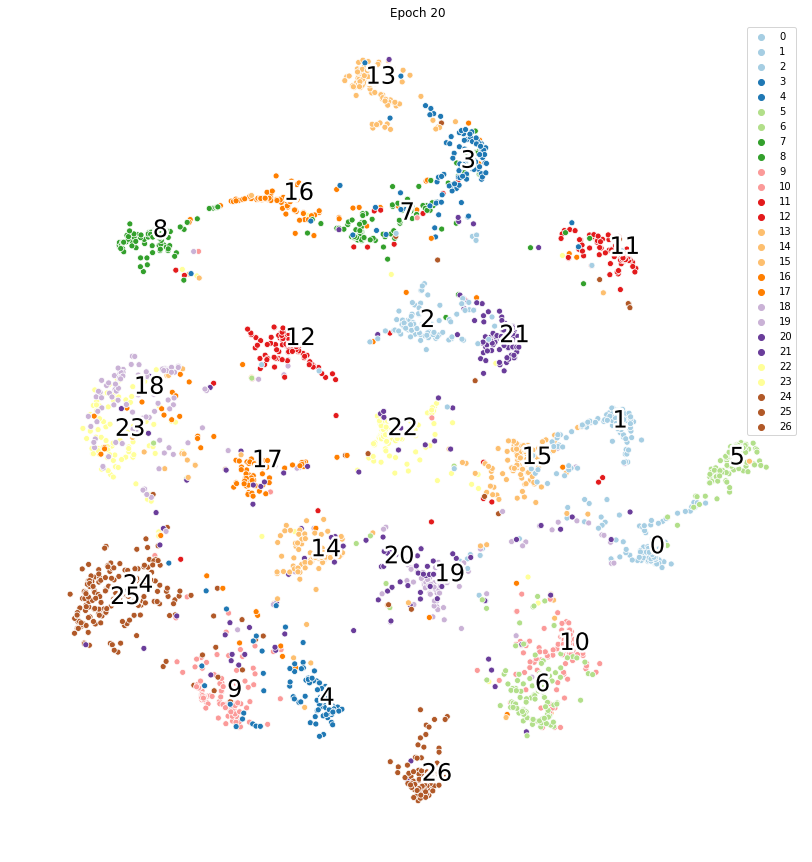

In [1]:
from keras.models import load_model
from create_model import create_base_network, in_dim, tripletize, std_triplet_loss
from keras.optimizers import SGD
import testing as T
import config as C
import os
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import matplotlib.patheffects as PathEffects
%matplotlib inline


def get_vectors(model, tdir=C.test_dir):
    classes = os.listdir(tdir)
    res = {}
    print('Embedding images...')
    for c in classes:         
            print(c)
            images = os.listdir(os.path.join(tdir,c))
            res[c] = [T.class_file(model, os.path.join(tdir,c,f)) for f in images]
    print('Done embedding images.')
    return res


for i in range(11,21):
    model_file = 'models/epoch_' + str(i) + '.model'
    print('Loading model from '+ model_file + '...')

    base_model = load_model(model_file)
    
    print('Compiling model...')
    model = tripletize(base_model)    
    model.compile(optimizer=SGD(lr=C.learn_rate, momentum=0.9),
                  loss=std_triplet_loss())

    vs = get_vectors(base_model, C.val_dir)

    df = pd.DataFrame()
    classes = os.listdir(C.val_dir)
    for c in classes:
        class_df = pd.DataFrame(np.asarray(vs[c]).reshape(100,64))
        class_df.insert(column='species', loc=0, value=c)    
        df = df.append(class_df)

    df = df.reset_index()
    df = df.drop(['index'], axis=1)

    X = np.asarray(df.drop(['species'],axis=1).values)
    tsne = TSNE(n_components=2, verbose=1, perplexity=50, early_exaggeration=20, n_iter=300, random_state=42).fit_transform(X)


    le = preprocessing.LabelEncoder()
    le.fit(df['species'])

    num_species = le.transform(df['species'])

    print(num_species)
    no_species = np.unique(num_species).size
    txts = []
    f = plt.figure(figsize=(15, 15))
    ax = plt.subplot(aspect='equal')
    ax.axis('off')

    for j in range(no_species):
        xtext, ytext = np.median(tsne[np.where(num_species == j)], axis=0)
        txt = ax.text(xtext, ytext, str(j), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"),PathEffects.Normal()])
        txts.append(txt)

    model_file = 'models/epoch_'+ str(i) + '.model'

    ax.set_title('Epoch ' + str(i))
    sns_plot = sns.scatterplot(tsne[:,0], tsne[:,1], hue=num_species, legend='full',
                    palette='Paired')
    fig = sns_plot.get_figure()
    fig.savefig('epoch_'+str(i)+'.png')
